In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [2]:
df = pd.read_csv("../data/raw_analyst_ratings.csv")
# news_df = df.copy()
news_df = df.sample(n=10000, random_state=42)


In [3]:
print("Basic Understanding of the dataset")
print(news_df.info())
print(news_df.head(2))

Basic Understanding of the dataset
<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 1201723 to 610523
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  10000 non-null  int64 
 1   headline    10000 non-null  object
 2   url         10000 non-null  object
 3   publisher   10000 non-null  object
 4   date        10000 non-null  object
 5   stock       10000 non-null  object
dtypes: int64(1), object(5)
memory usage: 546.9+ KB
None
         Unnamed: 0                                           headline  \
1201723     1207519  Syntel, Inc. Reports Q1 EPS of $1.11 vs $1.03 ...   
1282616     1288780  Mid-Day Market Update: K2M Group Rises On Acqu...   

                                                       url  \
1201723  https://www.benzinga.com/news/earnings/13/04/3...   
1282616  https://www.benzinga.com/news/18/08/12285391/m...   

                         publisher                 date stock  
1201

In [4]:
print("Basic Statistics for Textual Lengths in 'headline' Column")

news_df["headline_word_count"] = news_df["headline"].astype(str).str.split().str.len()
news_df["headline_char_count"] = news_df["headline"].astype(str).str.len()

colums_to_describe = ["headline_char_count", "headline_word_count"]

print(news_df[colums_to_describe].describe())


Basic Statistics for Textual Lengths in 'headline' Column
       headline_char_count  headline_word_count
count         10000.000000         10000.000000
mean             73.430000            11.476200
std              41.091789             6.459846
min              12.000000             2.000000
25%              47.000000             7.000000
50%              64.000000            10.000000
75%              87.000000            13.000000
max             397.000000            66.000000


In [5]:
print("Top 10 Most Active Publishers Based on Article Count:")

top_publishers = (
    news_df.groupby("publisher")
    .agg(article_count=("headline", "count"))
    .sort_values("article_count", ascending=False)
    .head(10)
    .reset_index()
)

print(top_publishers)

Top 10 Most Active Publishers Based on Article Count:
           publisher  article_count
0      Paul Quintaro           1620
1         Lisa Levin           1374
2  Benzinga Newsdesk           1091
3      Charles Gross            677
4      Monica Gerson            576
5       Eddie Staley            415
6         Hal Lindon            354
7      ETF Professor            210
8     Benzinga Staff            196
9         Vick Meyer            192


Publlication Trends over time


/var/folders/z4/j71xz2fs1270kjsdtgg3ckzh0000gn/T/ipykernel_96191/3258952542.py:3: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  news_df["date"] = pd.to_datetime(


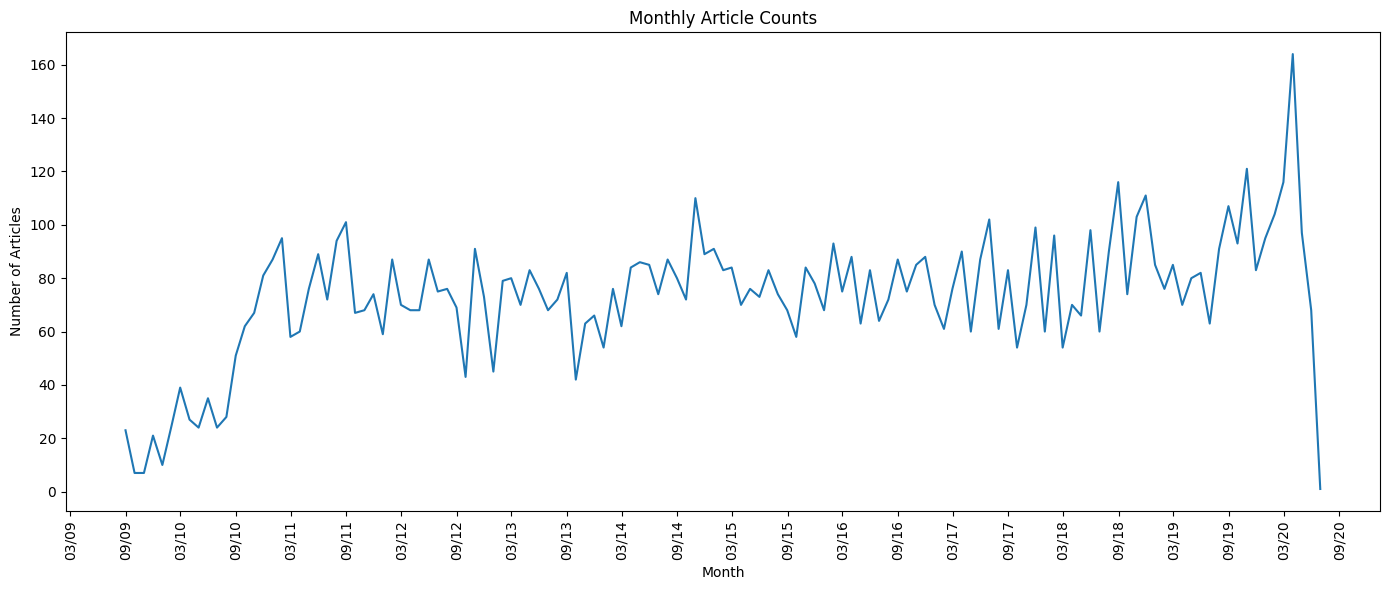

In [6]:
print("Publlication Trends over time")

news_df["date"] = pd.to_datetime(
    news_df["date"], errors="coerce", dayfirst=True, utc=True
).dt.tz_localize(None)

monthly_counts = news_df.resample("ME", on="date").size()

full_index = pd.date_range(
    start=monthly_counts.index.min(), end=monthly_counts.index.max(), freq="ME"
)

monthly_counts = monthly_counts.reindex(full_index, fill_value=0)

plt.figure(figsize=(14, 6))
plt.plot(monthly_counts.index, monthly_counts.values)
plt.title("Monthly Article Counts")
plt.xlabel("Month")
plt.ylabel("Number of Articles")


plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%m/%y"))

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [7]:
print("Text Analysis (Most common keywords):")

print("1. Clean Data")
news_df["clean_headline"] = (
    news_df["headline"].str.lower().str.replace(r"[^a-zA-Z0-9\s]", "", regex=True)
)

print("2. Extract Keywords")

vectorizer_uni = CountVectorizer(stop_words="english")
X_uni = vectorizer_uni.fit_transform(news_df["clean_headline"])

word_counts = (
    pd.DataFrame(
        X_uni.toarray().sum(axis=0),
        index=vectorizer_uni.get_feature_names_out(),
        columns=["count"],
    )
    .sort_values("count", ascending=False)
    .head(20)
)

print(word_counts)

print("3. Bigrams")
vectorizer_bi = CountVectorizer(stop_words="english", ngram_range=(2, 2))
X_bi = vectorizer_bi.fit_transform(news_df["clean_headline"])

bigram_counts = (
    pd.DataFrame(
        X_bi.toarray().sum(axis=0),
        index=vectorizer_bi.get_feature_names_out(),
        columns=["count"],
    )
    .sort_values("count", ascending=False)
    .head(20)
)

print(bigram_counts)

print("4. Topic Modeling")
tfidf = TfidfVectorizer(stop_words="english", max_features=5000)
X_tfidf = tfidf.fit_transform(news_df["clean_headline"])


print("LDA")
lda = LatentDirichletAllocation(
    n_components=5, random_state=42, learning_method="batch"  
)

lda.fit(X_tfidf)


words = tfidf.get_feature_names_out()


def display_topics(model, feature_names, n_top_words=10):
    for idx, topic in enumerate(model.components_):
        print(f"Topic {idx+1}:")
        print("  ".join([feature_names[i] for i in topic.argsort()[-n_top_words:]]))
        print()


display_topics(lda, words)

Text Analysis (Most common keywords):
1. Clean Data
2. Extract Keywords
            count
vs           1217
stocks       1198
est          1058
eps           947
shares        827
reports       776
update        679
market        664
earnings      617
sales         576
pt            525
announces     492
price         484
buy           460
trading       440
upgrades      429
raises        421
downgrades    411
target        407
benzingas     390
3. Bigrams
                    count
price target          351
stocks moving         327
market update         261
earnings scheduled    233
initiates coverage    212
premarket session     183
raises pt             179
q2 eps                173
companies trading     169
trading higher        159
adj eps               158
q3 eps                153
hit 52week            153
stocks hit            152
q1 eps                150
new 52week            147
reports q2            146
benzingas upgrades    144
vs est                141
trading lower      